In [1]:
import os 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from locscale.include.emmer.ndimage.map_utils import load_map, extract_window
from locscale.include.emmer.ndimage.profile_tools import compute_radial_profile, frequency_array, estimate_bfactor_standard

In [28]:
from tqdm import tqdm
import random
# set seed 
random.seed(0)

emmernet_output_dir = "/home/abharadwaj1/papers/elife_paper/figure_information/outputs/emmernet_test_hybrid_model_map_60k_dataset"
confidence_mask_dir = "/home/abharadwaj1/papers/elife_paper/figure_information/data/confidence_masks"
atomic_mask_dir = "/home/abharadwaj1/dev/data/atomic_model_mask"
target_model_map_dir = "/home/abharadwaj1/dev/map_sharpening/emmernet/locscale_inputs/hybrid_version_C/locscale_hybrid_version_C_model_maps"

bfactors_in_fdr_mask_all_emdb = {}
bfactors_in_atomic_mask_all_emdb = {}

for emdb_pdb in tqdm(os.listdir(emmernet_output_dir)):
    emdb, pdb = emdb_pdb.split("_")
    
    unsharpened_map_path = os.path.join(emmernet_output_dir, emdb_pdb, f"EMD_{int(emdb)}_unsharpened_fullmap.mrc")
    emmernet_output_path = os.path.join(emmernet_output_dir, emdb_pdb, f"emd_{emdb}_emmernet_output.mrc")
    target_model_map_path = os.path.join(target_model_map_dir, f"emd_{emdb}_hybrid_model_map_refined.mrc")
    fdr_mask_path = os.path.join(confidence_mask_dir, f"emd_{emdb}_FDR_confidence_final.map")
    atomic_mask_path = os.path.join(atomic_mask_dir, f"atomic_model_mask_{emdb_pdb}_strict_3A.mrc")
    
    if not os.path.exists(unsharpened_map_path) or not os.path.exists(fdr_mask_path) or not os.path.exists(atomic_mask_path):
        print(f"Skipping {emdb_pdb}")
        continue
    
    if not os.path.exists(emmernet_output_path) or not os.path.exists(target_model_map_path):
        print(f"Skipping {emdb_pdb} because emmernet output or target model map does not exist")
        continue
    
    unsharpened_map, apix = load_map(unsharpened_map_path)
    fdr_mask = load_map(fdr_mask_path)[0]
    atomic_mask = load_map(atomic_mask_path)[0]
    
    emmernet_map, _ = load_map(emmernet_output_path)
    target_model_map, _ = load_map(target_model_map_path)
    
    voxels_in_fdr_mask = np.asarray(np.where(fdr_mask > 0.99)).T.tolist()
    voxels_in_atomic_mask = np.asarray(np.where(atomic_mask > 0.5)).T.tolist()
    
    # exclude voxels near the edges of the map
    buffer_size =15
    voxel_near_z_edge = lambda voxel: voxel[0] < buffer_size or voxel[0] > fdr_mask.shape[0] - buffer_size 
    voxel_near_y_edge = lambda voxel: voxel[1] < buffer_size or voxel[1] > fdr_mask.shape[1] - buffer_size
    voxel_near_x_edge = lambda voxel: voxel[2] < buffer_size or voxel[2] > fdr_mask.shape[2] - buffer_size
    avoid_this_voxel = lambda voxel: voxel_near_z_edge(voxel) or voxel_near_y_edge(voxel) or voxel_near_x_edge(voxel)
    
    sample_size = 200 
    sample_voxels_in_fdr_mask = random.sample(voxels_in_fdr_mask, sample_size)
    sample_voxels_in_atomic_mask = random.sample(voxels_in_atomic_mask, sample_size)
    
    # exclude voxels near the edges of the map
    sample_voxels_in_fdr_mask_filter = [voxel for voxel in sample_voxels_in_fdr_mask if not avoid_this_voxel(voxel)]
    sample_voxels_in_atomic_mask_filter = [voxel for voxel in sample_voxels_in_atomic_mask if not avoid_this_voxel(voxel)]
    bfactors_in_fdr_mask = []
    bfactors_in_atomic_mask = []
    
    window_size_px = int(round(25/apix))
    
    wilson_cutoff = 10
    fsc_cutoff = apix * 2 +0.5
    for center in sample_voxels_in_fdr_mask_filter:
        emmernet_window = extract_window(emmernet_map, center, window_size_px)
        target_model_window = extract_window(target_model_map, center, window_size_px)
        
        rp_emmernet = compute_radial_profile(emmernet_window)
        rp_target_model = compute_radial_profile(target_model_window)
        
        freq = frequency_array(rp_emmernet, apix)
        try:
            bfactor_emmernet = estimate_bfactor_standard(freq, rp_emmernet, wilson_cutoff=wilson_cutoff, fsc_cutoff=fsc_cutoff)
            bfactor_target_model = estimate_bfactor_standard(freq, rp_target_model, wilson_cutoff=wilson_cutoff, fsc_cutoff=fsc_cutoff)
            
            bfactors_in_fdr_mask.append((bfactor_emmernet, bfactor_target_model))
        except:
            continue    
        
    for center in sample_voxels_in_atomic_mask_filter:
        emmernet_window = extract_window(emmernet_map, center, window_size_px)
        target_model_window = extract_window(target_model_map, center, window_size_px)
        
        rp_emmernet = compute_radial_profile(emmernet_window)
        rp_target_model = compute_radial_profile(target_model_window)
        
        freq = frequency_array(rp_emmernet, apix)
        
        try:
            bfactor_emmernet = estimate_bfactor_standard(freq, rp_emmernet, wilson_cutoff=wilson_cutoff, fsc_cutoff=fsc_cutoff)
            bfactor_target_model = estimate_bfactor_standard(freq, rp_target_model, wilson_cutoff=wilson_cutoff, fsc_cutoff=fsc_cutoff)
            
            bfactors_in_atomic_mask.append((bfactor_emmernet, bfactor_target_model))
        except:
            continue
            
    bfactors_in_fdr_mask_all_emdb[emdb_pdb] = bfactors_in_fdr_mask
    bfactors_in_atomic_mask_all_emdb[emdb_pdb] = bfactors_in_atomic_mask


 14%|█▍        | 2/14 [00:06<00:38,  3.23s/it]

Skipping 0560_6nzu because emmernet output or target model map does not exist


 43%|████▎     | 6/14 [00:14<00:19,  2.41s/it]

Skipping 3545_5mqf
Skipping 4141_5m1s because emmernet output or target model map does not exist
Skipping 4531_6qdw


 71%|███████▏  | 10/14 [00:17<00:05,  1.33s/it]/home/abharadwaj1/dev/locscale/locscale/include/emmer/ndimage/profile_tools.py:368: RuntimeWarning: divide by zero encountered in log
  ydata = np.log(amplitude[start_index:end_index])
100%|██████████| 14/14 [00:30<00:00,  2.17s/it]


In [29]:
def plot_correlations(x_array, y_array,  x_label, y_label, title_text, \
                    scatter=False, figsize_cm=(14,8),font="Helvetica",fontsize=10,\
                    fontscale=1,hue=None,find_correlation=True, alpha=0.3, filepath=None,\
                    xticks=None, yticks=None, xlim=None, ylim=None):

    import matplotlib.pyplot as plt
    from matplotlib.pyplot import cm
    from locscale.include.emmer.ndimage.profile_tools import crop_profile_between_frequency
    import seaborn as sns
    from scipy import stats
    from sklearn.metrics import r2_score
    import matplotlib 
    import pandas as pd
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    # set the global font size for the plot

        
    plt.rcParams.update({'font.size': fontsize})
    figsize = (figsize_cm[0]/2.54, figsize_cm[1]/2.54) # convert cm to inches
    
    fig = plt.figure(figsize=figsize, dpi=600) # dpi=600 for publication quality
    sns.set_theme(context="paper", font=font, font_scale=fontscale)
    # Set font size for all text in the figure
    sns.set_style("white")
    
    def annotate(data, **kws):
        pearson_correlation = stats.pearsonr(x_array, y_array)
        r2 = r2_score(x_array, y_array)
        r2_text = f"$R$ = {pearson_correlation[0]:.2f}"
        #r2_text = f"$R^2$ = {r2:.2f}"
        ax = plt.gca()
        ax.text(.05, .8, r2_text,transform=ax.transAxes)
    # Create a pandas dataframe for the data
    data = pd.DataFrame({x_label: x_array, y_label: y_array})
    # Plot the data    
    g = sns.lmplot(x=x_label, y=y_label, data=data, scatter=scatter)
    g.map_dataframe(annotate)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.tight_layout()

    if xticks is not None:
        plt.xticks(xticks)
    if yticks is not None:
        plt.yticks(yticks)
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    if filepath is not None:
        plt.savefig(filepath, bbox_inches='tight')
    else:
        # return the figure object
        return fig

In [30]:
bfactors_emmernet_fdr_mask = []
bfactors_target_model_fdr_mask = []
bfactors_emmernet_atomic_mask = []
bfactors_target_model_atomic_mask = []

for emdb_pdb in bfactors_in_fdr_mask_all_emdb:
    bfactors_emmernet_fdr_mask += [-1* bfactor[0] for bfactor in bfactors_in_fdr_mask_all_emdb[emdb_pdb]]
    bfactors_target_model_fdr_mask += [-1 * bfactor[1] for bfactor in bfactors_in_fdr_mask_all_emdb[emdb_pdb]]
    
    bfactors_emmernet_atomic_mask += [-1 * bfactor[0] for bfactor in bfactors_in_atomic_mask_all_emdb[emdb_pdb]]
    bfactors_target_model_atomic_mask += [-1 * bfactor[1] for bfactor in bfactors_in_atomic_mask_all_emdb[emdb_pdb]]
    

<Figure size 1417.32x944.882 with 0 Axes>

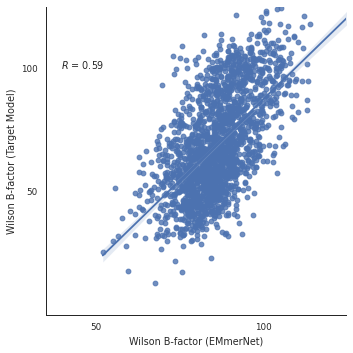

In [31]:
kwargs = {
    "figsize_cm":(6,4),
    "font":"Helvetica",
    "fontsize":18,
    "find_correlation":True,
    "alpha":0.3,
    "x_label":"Wilson B-factor (EMmerNet)",
    "y_label":"Wilson B-factor (Target Model)",
    "title_text":"B-factor correlation",
    "scatter":True,
    "xticks":[50, 100],
    "yticks":[50, 100],
    "xlim":[35, 125],
    "ylim":[0, 125],
}

plot_output_dir = "/home/abharadwaj1/papers/elife_paper/figure_information/outputs/emmernet_bfactor_correlation"
fig_correlation_fdr = plot_correlations(bfactors_emmernet_fdr_mask, bfactors_target_model_fdr_mask, \
                                        filepath=os.path.join(plot_output_dir, "emmernet_bfactor_correlation_fdr_mask2.png"),\
                                        **kwargs)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 1417.32x944.882 with 0 Axes>

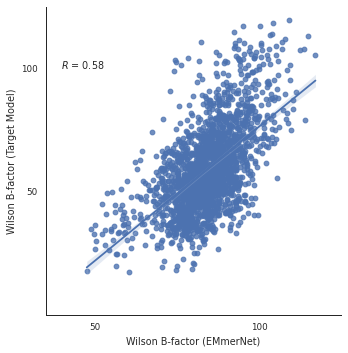

In [29]:
fig_correlation_atomic = plot_correlations(bfactors_emmernet_atomic_mask, bfactors_target_model_atomic_mask, 
                                        filepath=os.path.join(plot_output_dir, "emmernet_bfactor_correlation_atomic_mask.eps"),\
                                        **kwargs)

In [27]:
plot_output_dir = "/home/abharadwaj1/papers/elife_paper/figure_information/outputs/emmernet_bfactor_correlation"

fig_correlation_fdr.savefig(os.path.join(plot_output_dir, "emmernet_bfactor_correlation_fdr_mask.eps"), dpi=600)
fig_correlation_fdr.savefig(os.path.join(plot_output_dir, "emmernet_bfactor_correlation_fdr_mask.png"), dpi=600)

fig_correlation_atomic.savefig(os.path.join(plot_output_dir, "emmernet_bfactor_correlation_atomic_mask.eps"), dpi=600)
fig_correlation_atomic.savefig(os.path.join(plot_output_dir, "emmernet_bfactor_correlation_atomic_mask.png"), dpi=600)


In [30]:
import pickle
all_results = {
    "bfactors_emmernet_fdr_mask":bfactors_emmernet_fdr_mask,
    "bfactors_target_model_fdr_mask":bfactors_target_model_fdr_mask,
    "bfactors_emmernet_atomic_mask":bfactors_emmernet_atomic_mask,
    "bfactors_target_model_atomic_mask":bfactors_target_model_atomic_mask,
    "wilson_cutoff":wilson_cutoff,
    "fsc_cutoff":"nyquist + 0.5"
    
}

with open(os.path.join(plot_output_dir, "emmernet_bfactor_correlation.pickle"), "wb") as f:
    pickle.dump(all_results, f)